# Face mask detection using CNN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# For reading images and image manipulation
import os
import cv2
import glob

# For Machine Learning
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.densenet import DenseNet169
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

# For confusion matrix, precision, recall,  f1-score
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# To export the tested model into a pickle file
import pickle

print('Successfully import all libraries ')

Successfully import all libraries 


In [2]:
os.listdir('dataset')

['no_mask', 'with_mask']

In [3]:
images_no_mask = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob('dataset/no_mask/**/*.png',recursive=True)]
images_with_mask = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob('dataset/with_mask/**/*.png',recursive=True)]

In [4]:
print("Number of image without mask:",len(images_no_mask))
print("Number of image with mask:",len(images_with_mask))

Number of image without mask: 446
Number of image with mask: 470


#### Making dataframe with images and their level

***Level:***
- with_mask : 0
- no_mask : 1

In [5]:
y_0 = np.zeros(len(images_with_mask))
y_1 = np.ones(len(images_no_mask))

In [6]:
df1 = pd.DataFrame(images_no_mask)
df2 = pd.DataFrame(images_with_mask)

C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [7]:
df1['level'] = y_1
df2['level'] = y_0

In [8]:
df1.head(3)

,0,level
0,"[[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, ...",1.0
1,"[[65, 51, 41, 38, 31, 25, 32, 48, 48, 57, 66, ...",1.0
2,"[[108, 108, 118, 138, 148, 136, 111, 90, 76, 7...",1.0


In [9]:
df2.head(3)

,0,level
0,"[[195, 194, 194, 193, 193, 193, 192, 192, 192,...",0.0
1,"[[28, 28, 28, 28, 28, 21, 21, 21, 28, 28, 28, ...",0.0
2,"[[64, 96, 159, 118, 127, 143, 156, 151, 155, 1...",0.0


In [10]:
df = pd.concat([df1, df2], ignore_index=True) # Concate two leveled dataframe

In [11]:
df.head(3)

,0,level
0,"[[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, ...",1.0
1,"[[65, 51, 41, 38, 31, 25, 32, 48, 48, 57, 66, ...",1.0
2,"[[108, 108, 118, 138, 148, 136, 111, 90, 76, 7...",1.0


In [12]:
df.tail(3)

,0,level
913,"[[235, 228, 213, 205, 211, 213, 217, 220, 213,...",0.0
914,"[[235, 240, 244, 243, 242, 242, 242, 244, 246,...",0.0
915,"[[63, 63, 62, 60, 59, 58, 58, 59, 60, 61, 61, ...",0.0


In [13]:
df3 = df.rename(columns={0 : "image"})
df3.head(3)

,image,level
0,"[[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, ...",1.0
1,"[[65, 51, 41, 38, 31, 25, 32, 48, 48, 57, 66, ...",1.0
2,"[[108, 108, 118, 138, 148, 136, 111, 90, 76, 7...",1.0


In [14]:
df4 = df3.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe and reindexing
df4.head(10)

,image,level
0,"[[65, 64, 67, 80, 102, 122, 131, 130, 124, 130...",1.0
1,"[[201, 201, 201, 201, 201, 201, 201, 202, 202,...",0.0
2,"[[26, 27, 26, 29, 29, 30, 31, 31, 33, 35, 36, ...",1.0
3,"[[100, 100, 96, 88, 84, 86, 87, 87, 90, 90, 92...",1.0
4,"[[246, 246, 246, 247, 247, 247, 247, 247, 246,...",0.0
5,"[[15, 14, 13, 11, 9, 7, 6, 6, 10, 11, 8, 7, 11...",1.0
6,"[[53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, ...",0.0
7,"[[185, 176, 169, 167, 171, 175, 172, 165, 174,...",1.0
8,"[[181, 168, 156, 137, 118, 107, 106, 107, 106,...",0.0
9,"[[116, 117, 117, 117, 118, 118, 119, 119, 120,...",0.0


In [15]:
df4.isnull().sum()

image    2
level    0
dtype: int64

In [16]:
df5 = df4.dropna() # Drop null values

In [17]:
df5.isnull().sum()

image    0
level    0
dtype: int64

#### Ploting the number of data in each level

In [18]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

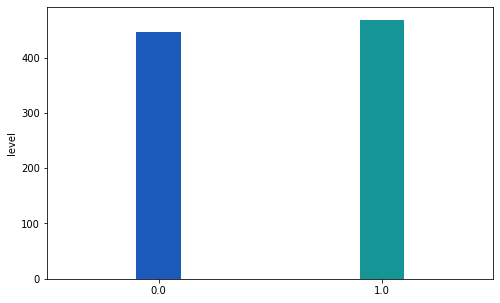

In [19]:
sns.set_style()
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=df5.level.unique(),y=df5.level.value_counts(),palette='winter',ax=ax)
change_width(ax, .20)
plt.show()

C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

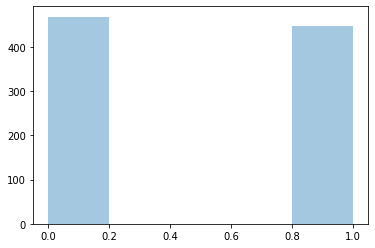

In [20]:
sizes = df5['level'].values
sns.distplot(sizes, kde=False)

#### Plot of the images

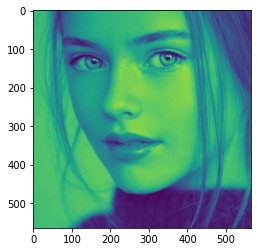

In [21]:
plt.imshow(df3['image'][55])
plt.show()

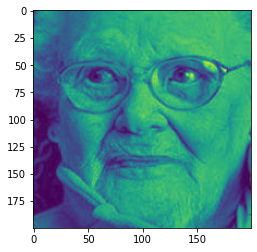

In [22]:
plt.imshow(df5['image'][0])
plt.show()

In [23]:
X = df5['image']
y = df5['level']

In [24]:
data = []
for im in X:
    new = cv2.resize(im, (50,50)) # Resizing the image
    data.append(new)

In [25]:
X_tt = []
for im in data:
    X_tt.append(tf.convert_to_tensor(im))
type(X_tt)

list

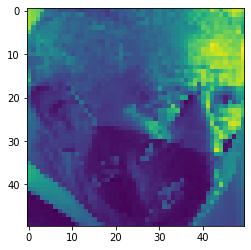

In [26]:
plt.imshow(X_tt[10])
plt.show()

In [27]:
x = np.array(X_tt).reshape(-1, 50, 50, 1)

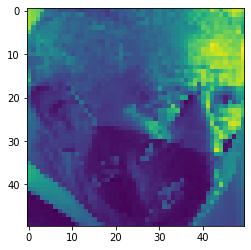

In [28]:
plt.imshow(x[10])
plt.show()

In [29]:
x.shape

(914, 50, 50, 1)

In [30]:
# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)

# Converting it into a categorical variable
y = to_categorical(y)

In [31]:
y.shape

(914, 2)

#### Split dataset into train and test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [33]:
print('Training Features Shape: ', X_train.shape)
print('Training Labels Shape: ', y_train.shape)
print('Testing Features Shape: ', X_test.shape)
print('Testing Labels Shape: ', y_test.shape)

Training Features Shape:  (685, 50, 50, 1)
Training Labels Shape:  (685, 2)
Testing Features Shape:  (229, 50, 50, 1)
Testing Labels Shape:  (229, 2)


#### Creating the 2D-CNN architecture using the Sequential model from TensorFlow

In [34]:
input_img_shape = x.shape[1:]
print(input_img_shape)

(50, 50, 1)


In [35]:
# Initializing a sequential keras model
model_1 = Sequential()

# Adding a 2D convolution layer
model_1.add(
    Conv2D(
        filters=100,
        kernel_size=(3, 3),
        use_bias=True,
        input_shape=input_img_shape,
        activation="relu",
        strides=2,
    )
)

# Adding a max-pooling layer
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a 2D convolution layer 
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

# Adding a max-pooling layer 
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flatten layer 
model_1.add(Flatten())

# Adding dropout
model_1.add(Dropout(0.2))

# Adding a dense layer 
model_1.add(Dense(50, activation="relu"))

# Adding a dropout
model_1.add(Dropout(0.2))

# Adding a dense layer with softmax activation
model_1.add(Dense(2, activation="softmax"))

# Printing the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        57664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [36]:
start_time = datetime.now()

# Initializing an Adam optimizer
opt = Adam(lr=1e-3, decay=1e-5)

# Configuring the model for training
model_1.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
history_1 = model_1.fit(X_train, y_train, epochs=30, batch_size=5, validation_split=0.2)

end_time = datetime.now()
print("\n*Time required to train model: ",end_time - start_time)

C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
110/110 [==============================] - 2s 10ms/step - loss: 3.0191 - accuracy: 0.5730 - val_loss: 0.5839 - val_accuracy: 0.7299
Epoch 2/30
110/110 [==============================] - 1s 8ms/step - loss: 0.4991 - accuracy: 0.7646 - val_loss: 0.3249 - val_accuracy: 0.8832
Epoch 3/30
110/110 [==============================] - 1s 8ms/step - loss: 0.3015 - accuracy: 0.8832 - val_loss: 0.2269 - val_accuracy: 0.9343
Epoch 4/30
110/110 [==============================] - 1s 8ms/step - loss: 0.2145 - accuracy: 0.9234 - val_loss: 0.2725 - val_accuracy: 0.8978
Epoch 5/30
110/110 [==============================] - 1s 8ms/step - loss: 0.1980 - accuracy: 0.9453 - val_loss: 0.2109 - val_accuracy: 0.9197
Epoch 6/30
110/110 [==============================] - 1s 8ms/step - loss: 0.1469 - accuracy: 0.9507 - val_loss: 0.2538 - val_accuracy: 0.9343
Epoch 7/30
110/110 [==============================] - 1s 8ms/step - loss: 0.1684 - accuracy: 0.9361 - val_loss: 0.2458 - val_accuracy: 0.9270
Epoch

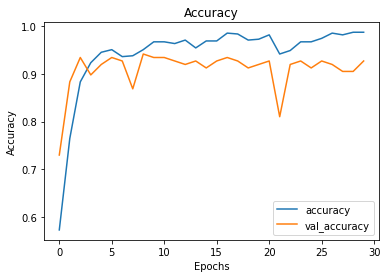

In [37]:
pd.DataFrame(history_1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

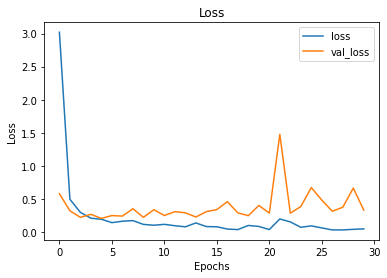

In [38]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### Creating the DenseNet169 architecture using the Sequential model from TensorFlow

In [39]:
model_2 = Sequential()

# Adding DenseNet169
model_2.add(DenseNet169(input_shape=(50,50,1),include_top=True,weights=None))

# Adding a flatten layer
model_2.add(Flatten())

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding a dense layer
model_2.add(Dense(64,kernel_initializer='he_uniform',activation="relu"))

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding dropout
model_2.add(Dropout(0.2))

# Adding a dense layer
model_2.add(Dense(128,kernel_initializer='he_uniform',activation="relu"))

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding dropout
model_2.add(Dropout(0.2))

# Adding a dense layer
model_2.add(Dense(256,kernel_initializer='he_uniform',activation="relu"))

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding dropout
model_2.add(Dropout(0.2))

# Adding a dense layer
model_2.add(Dense(64,kernel_initializer='he_uniform',activation="relu"))

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding dropout
model_2.add(Dropout(0.2))

# Adding a dense layer
model_2.add(Dense(32,kernel_initializer='he_uniform',activation="relu"))

# Adding a batch normalization layer
model_2.add(BatchNormalization())

# Adding dropout
model_2.add(Dropout(0.2))

# Creating an output layer
model_2.add(Dense(units= 2, activation='softmax'))

c3 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)

# Printing the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1000)              14301608  
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                64064     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [40]:
start_time = datetime.now()

# Configuring the model for training
model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])

# Training the model
history_2 = model_2.fit(X_train,y_train,epochs=30,batch_size=5,validation_split=0.2)

end_time = datetime.now()
print("\n*Time required to train model_1: ",end_time - start_time)

Epoch 1/30
110/110 [==============================] - 47s 259ms/step - loss: 0.9716 - accuracy: 0.5529 - auc: 0.5641 - val_loss: 0.7036 - val_accuracy: 0.5109 - val_auc: 0.5415
Epoch 2/30
110/110 [==============================] - 25s 223ms/step - loss: 0.9541 - accuracy: 0.5128 - auc: 0.5287 - val_loss: 0.6640 - val_accuracy: 0.6131 - val_auc: 0.6517
Epoch 3/30
110/110 [==============================] - 26s 233ms/step - loss: 0.7714 - accuracy: 0.5803 - auc: 0.6288 - val_loss: 0.6779 - val_accuracy: 0.5036 - val_auc: 0.5860
Epoch 4/30
110/110 [==============================] - 26s 240ms/step - loss: 0.7640 - accuracy: 0.5693 - auc: 0.5862 - val_loss: 0.6800 - val_accuracy: 0.6642 - val_auc: 0.6498
Epoch 5/30
110/110 [==============================] - 26s 235ms/step - loss: 0.6923 - accuracy: 0.6150 - auc: 0.6588 - val_loss: 0.7424 - val_accuracy: 0.5985 - val_auc: 0.6279
Epoch 6/30
110/110 [==============================] - 26s 235ms/step - loss: 0.7044 - accuracy: 0.5912 - auc: 0.636

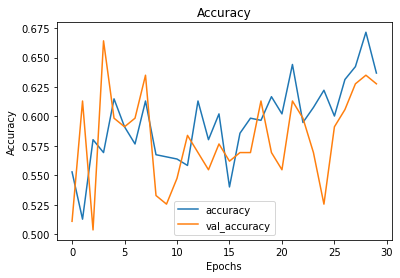

In [41]:
pd.DataFrame(history_2.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

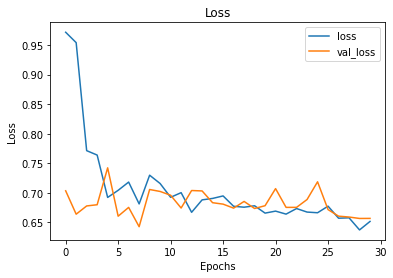

In [42]:
pd.DataFrame(history_2.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### Test Loss and Test Accuracy of two models

In [43]:
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

8/8 [==============================] - 0s 10ms/step - loss: 0.2152 - accuracy: 0.9389
Test loss: 0.21520046889781952
Test accuracy: 0.9388646483421326


In [44]:
test_loss, test_acc, test_auc = model_2.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test auc:', test_auc)

8/8 [==============================] - 2s 168ms/step - loss: 0.6446 - accuracy: 0.6594 - auc: 0.6776
Test loss: 0.6445727348327637
Test accuracy: 0.6593886613845825
Test auc: 0.677618682384491


***Based on above results we can say that 2D-CNN gives the best score. Hence we will use that***

In [45]:
model = model_1
predictions = model.predict(X_test)

In [46]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [47]:
def Print_level(i):
    plt.imshow(X_test[i].reshape(50, 50), cmap = plt.cm.binary)
    plt.show()
    if(np.argmax(np.round(predictions[i])) == 0):
        return print('Images with mask'.center(50,'-'))
    else: return print('Images with no mask'.center(60,'-'))

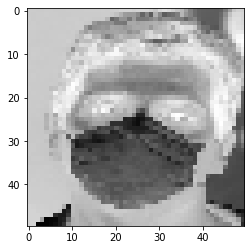

-----------------Images with mask-----------------


In [48]:
Print_level(0)

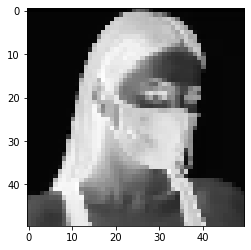

-----------------Images with mask-----------------


In [49]:
Print_level(1)

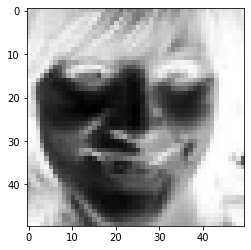

--------------------Images with no mask---------------------


In [50]:
Print_level(3)

In [51]:
y_pred = [np.argmax(np.round(predictions[i])) for i in range(len(X_test))]
y_true = [np.argmax(y_test[i]) for i in range(len(X_test))]

In [52]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.inferno):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

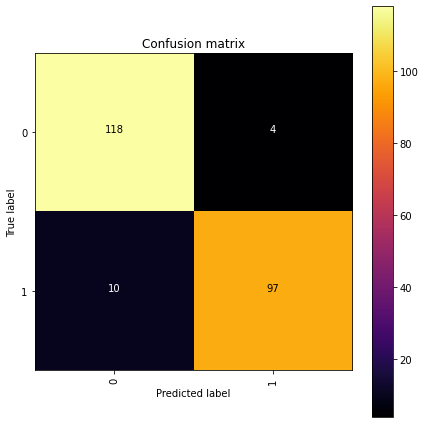

In [53]:
cm = confusion_matrix(y_true,y_pred)
cm_plot = plot_confusion_matrix(cm,classes=['0','1'])

In [54]:
print('Performance Report (Accuracy score is) :', metrics.accuracy_score(y_true, y_pred),'\n\n')
target=['0','1']
print('Classification Report'.center(65,'-'),'\n', metrics.classification_report(y_true,y_pred,target_names=target))

Performance Report (Accuracy score is) : 0.9388646288209607 


----------------------Classification Report---------------------- 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       122
           1       0.96      0.91      0.93       107

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.94      0.94      0.94       229



#### Export the tested model to a pickle file

In [55]:
with open('Face_mask_detection_model.pickle','wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://ce539e21-459b-422a-8e01-4f95d7ed2c59/assets
